<a href="https://colab.research.google.com/github/libra3910/diveintocode-ml/blob/master/sprint_cnn_conv1_newral_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sprint 深層学習スクラッチ ディープニューラルネットワーク

In [ ]:
import numpy as np

### ミニバッチ

In [ ]:
# Utilityクラス
# GetMiniBatch
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 20, seed=0):
        
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        
        return self._stop
    
    def __getitem__(self,item):
        
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        
        return self._X[p0:p1], self._y[p0:p1]   
    
    def __iter__(self):
        
        self._counter = 0
        
        return self
    
    def __next__(self):
        
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        
        return self._X[p0:p1], self._y[p0:p1]

### 全結合層

In [ ]:
# Initializerクラス
# SimpleInitializer 【問題2】初期化方法のクラス化
class SimpleInitializer:
    
    def __init__(self, sigma, seed=0):
        
        self.sigma = sigma
        self.seed = seed
        np.random.seed(self.seed)
        
    def W(self, n_nodes1, n_nodes2):
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

In [ ]:
# Xavier
class Xavier:
    """
    初期値を正規分布化するため、前層のノード数の根で除算する。
    活性化関数がシグモイド関数やハイパボリックタンジェント関数の場合に適用。
    
    """
    def __init__(self, sigma, seed=0):
        
        self.sigma = sigma
        self.seed = seed
        np.random.seed(self.seed)
        
    def W(self, n_nodes1, n_nodes2):
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2) * (1 / np.sqrt(n_nodes1))
        
        return W
    
    def B(self, n_nodes2):
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

In [ ]:
# He
class He:
    """
    （2×前層のノード数の根）で除算する。
    活性化関数がReLU関数の場合に適用。
    
    """
    def __init__(self, sigma, seed=0):
        
        self.sigma = sigma
        self.seed = seed
        np.random.seed(self.seed)
        
    def W(self, n_nodes1, n_nodes2):
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2) * (2 / np.sqrt(n_nodes1))
        
        return W
    
    def B(self, n_nodes2):
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

In [ ]:
# Optimizerクラス
# SGD
class SGD:

    def __init__(self, lr):
        
        self.lr = lr
        
    def update(self, layer):

        #layer.W -= self.lr * np.dot(layer.X.T, layer.dA)
        #layer.B -= self.lr * np.sum(layer.dA, axis=0)
        layer.W -= self.lr * layer.dAW
        layer.B -= self.lr * layer.dAB
        
        return layer

In [ ]:
# AdaGrad
class AdaGrad:

    def __init__(self, lr):
        
        self.lr = lr
        self.HiW = 0
        self.HiB = 0
        
    def update(self, layer):
        
        self.HiW += layer.dAW ** 2
        self.HiB += layer.dAB ** 2
        
        layer.W -= self.lr * (1 / (np.sqrt(self.HiW) + 1e-7)) * layer.dAW
        layer.B -= self.lr * (1 / (np.sqrt(self.HiB) + 1e-7)) * layer.dAB
        
        return layer
        

In [ ]:
# Layerクラス
# FC
class FC:

    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):

        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.optimizer = optimizer

        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する

        self.W = self.initializer.W(n_nodes1, n_nodes2)
        self.B = self.initializer.B(n_nodes2)
        self.X = None
        self.dA = None
        
    def forward(self, X):

        self.X = X
        A = np.dot(self.X, self.W) + self.B
        return A
    
    def backward(self, dA):

        self.dA = dA

        self.dAW = np.dot(self.X.T, self.dA)
        self.dAB = np.sum(self.dA, axis=0)
        
        dz = np.dot(dA, self.W.T)
        
        self = self.optimizer.update(self)

        return dz


In [ ]:
# ReLU
class ReLU:

    def __init__(self):

        self.A = None
    
    def forward(self, X):
  
        self.A = np.copy(X)
        
        return np.maximum(0, X)
        
    def backward(self, dA):

        return np.where(self.A > 0, dA, 0)

In [ ]:
# Tanh
class Tanh:

    def __init__(self):

        pass

    def forward(self, X):

        self.Z = (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))
        return self.Z
        
    def backward(self, dA):
        
        dA2 = dA * (1 - self.Z**2)
        
        return dA2

In [ ]:
# Softmax
class Softmax:
    
    def __init__(self):
        
        pass
    
    def forward(self, X):
        
        dz = np.exp(X) / np.sum(np.exp(X), axis=1, keepdims=True)
        return dz
    
    def backward(self, Z3, y):

        y_one_hot = (y.reshape(-1,1)==np.arange(10))
        dza = (Z3 - y) / y.shape[0]
        #【問題3】交差エントロピー誤差の実装
        L = np.sum(np.mean(-(y_one_hot * Z3), axis=0))
        C = np.sum(np.array(dza).argmax(axis=1) == y)
        
        return dza, L, C

In [ ]:
# Calculates log(sum(exp(x)))
class logsumexp:
    
    def __init__(self):

        pass

    def forward(self, X):
        
        xmax = X.max(axis=1, keepdims=True)
        self.Z = np.log(np.exp(X - xmax).sum(axis=1, keepdims=True)) + xmax
        
        return self.Z

    def backward(self, Z3, log_Z3, y):

        y_one_hot = (y.reshape(-1,1)==np.arange(10))
        dza = (Z3 - y_one_hot) / y_one_hot.shape[0]

        L = np.sum(np.mean(-(y_one_hot * log_Z3), axis=0))
        C = np.sum(Z3.argmax(axis=1) == y)
        
        return dza, L, C

### 畳み込み層

In [ ]:
# Initializerクラス
# SimpleInitializer 【問題2】初期化方法のクラス化
class SimpleInitializerConv1d:
    
    def __init__(self, sigma, seed=0):
        
        self.sigma = sigma
        self.seed = seed
        np.random.seed(self.seed)
        
    def W(self, out_channel, in_channel, filter_size):
        
        W = self.sigma * np.random.randn(out_channel, in_channel, filter_size)
        
        return W
    
    def B(self, out_channel):
        
        B = self.sigma * np.random.randn(out_channel)
        
        return B

In [ ]:
# 1次元畳み込み層
class SimpleConv1d:
    
    def __init__(self, out_channel, in_channel, filter_size,
                padding_size = 0, stride_size = 1,
                initializer = None, optimizer = None):
        
        self.padding_size = padding_size
        self.stride_size = stride_size
        self.initializer = initializer
        self.optimizer = optimizer
        
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する

        self.W = self.initializer.W(out_channel, in_channel, filter_size)
        self.B = self.initializer.B(out_channel)
        self.X = None
        self.dA = None
        
    def forward(self, X):

        self.X = X[:, np.newaxis, :]
        self.N_out = int((self.X.shape[2] + 2 * self.padding_size - self.W.shape[2]) / self.stride_size) + 1 # 【問題２】1次元畳み込み後の出力サイズの計算
        
        a = np.array([])
        for n in range(self.X.shape[0]):
            Yhat = np.array([])
            for j in range(self.N_out):
                Yhat_tmp = 0
                for i in range(self.X.shape[1]): # ストライドする分はループが必要か
                    Yhat_tmp += (self.X[n, i, j:j+self.W.shape[2]].dot(self.W[n, i, :])).astype(np.float64)
                Yhat = np.append(Yhat, np.sum(Yhat_tmp, axis=0) + self.B[n])

            a = np.append(a, Yhat)
        
        a = a.reshape(self.X.shape[0], self.N_out)

        return a
        
    def backward(self, delta_a):
        
        delta_a = delta_a[:, np.newaxis, :]
        
        # Xを更新
        self.aX = np.zeros(self.X.shape)
        for n in range(self.X.shape[0]):
            for j in range(self.W.shape[0]):
                for i in range(self.W.shape[1]):
                    for h in range(self.W.shape[2]):
                        for k in range(self.N_out):
                            self.aX[n, i, h+k] += (self.W[j, i, h] * delta_a[n, i, k]).astype(np.float64)

        # Wを更新
        self.dAW = np.zeros(self.W.shape)
        for n in range(self.X.shape[0]):
            for j in range(self.W.shape[0]):
                for i in range(self.W.shape[1]):
                    for h in range(self.W.shape[2]):
                        for k in range(self.N_out):
                            self.dAW[j, i, h] += (self.X[n, i, h+k] * delta_a[n, i, k]).astype(np.float64)
                            
        # Bを更新

        self.dAB = np.sum(delta_a.reshape(self.X.shape[0], -1), axis=1)

        self = self.optimizer.update(self)
        
        return self.aX

### 学習および推定

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# Tranerクラス
class ScratchDeepNeuralNetrowkClassifier():
    """
    Trainerクラスの定義
    
    """
    # self.sigma : ガウス分布の標準偏差
    # self.lr : 学習率
    # self.n_nodes1 : 1層目のノード数
    # self.n_nodes2 : 2層目のノード数
    # self.n_output : 出力層のノード数
    
    batch_size = 20
    sigma = 0.01
    n_features = 782
    n_nodes1 = 400
    n_nodes2 = 200
    n_output = 10
    lr = 0.01

    def __init__(self, seed=0, verbose = True, verbose2 = False):
        
        self.seed = 0
        self.verbose = verbose
        self.verbose2 = verbose2

    def fit(self, X, y, X_val=None, y_val=None, pinit="Initializer", pact1="Tanh", pact2="logsumexp", popt="SGD",
            cinit = "InitializerConv1d", cact = "ReLU", copt = "SGD", 
            out_channel = 20, in_channel = 1, filter_size = 3, padding_size = 0, stride_size = 1):

        # 畳み込み層　初期化、学習用の各関数を定義
        # 初期化関数
        if cinit == "InitializerConv1d":
            initializerConv1d =SimpleInitializerConv1d(self.sigma, self.seed)
        
        # 最適化関数
        if copt == "SGD":
            optimizerConv1d = SGD(self.lr)
        
        # 活性化関数
        if cact == "ReLU":
            self.activationConv1d = ReLU()
        
        # 学習用関数初期化
        if copt == "SGD":
            self.Conv1d = SimpleConv1d(out_channel, in_channel, filter_size, padding_size, stride_size, 
                                       initializerConv1d, optimizerConv1d)
       
        # 全結合層　初期化、最適化、活性化、学習用の各関数を定義
        # 初期化関数
        if pinit == "Initializer":
            initializer = SimpleInitializer(self.sigma, self.seed)
        elif pinit == "Xavier":
            initializer = Xavier(self.sigma, self.seed)
        elif pinit == "He":
            initializer = He(self.sigma, self.seed)
        
        # 最適化関数
        if popt == "SGD":
            optimizer = SGD(self.lr)
        elif popt == "AdaGrad":
            optimizer1 = AdaGrad(self.lr) 
            optimizer2 = AdaGrad(self.lr) 
            optimizer3 = AdaGrad(self.lr) 
        
        # 活性化関数1
        if pact1 == "Tanh":
            self.activation1 = Tanh()
            self.activation2 = Tanh()
        if pact1 == "ReLU":
            self.activation1 = ReLU()
            self.activation2 = ReLU()

        # 活性化関数2
        if pact2 == "logsumexp":
            self.activation3 = logsumexp()
        elif pact2 == "Softmax":
            self.activation3 = Softmax()
        
        # 学習用関数初期化
        if popt == "SGD":
            self.FC1 = FC(self.n_features, self.n_nodes1, initializer, optimizer) # W1: (782, 400)
            self.FC2 = FC(self.n_nodes1, self.n_nodes2, initializer, optimizer) # W2: (400, 200) 
            self.FC3 = FC(self.n_nodes2, self.n_output, initializer, optimizer) # W3: (200, 10)
        elif popt == "AdaGrad":
            self.FC1 = FC(self.n_features, self.n_nodes1, initializer, optimizer1) # W1: (782, 400)
            self.FC2 = FC(self.n_nodes1, self.n_nodes2, initializer, optimizer2) # W2: (400, 200) 
            self.FC3 = FC(self.n_nodes2, self.n_output, initializer, optimizer3) # W3: (200, 10)            
        
        epoch = 20
        n_step_iteration_report = 1
        plot_data = []
        
        # Utility(epochごとに、全データ分ミニバッチを取得)
        for i in range(epoch):

            sum_of_loss = 0
            get_mini_batch = GetMiniBatch(X, y, batch_size = self.batch_size)
            for j, (mini_X_train, mini_y_train) in enumerate(get_mini_batch):
                
                # 畳み込み層　学習用Forward Propergation
                C1  = self.Conv1d.forward(mini_X_train)
                ZC1 = self.activationConv1d.forward(C1)
                
                # 全結合層　学習用Forward Propergation
                A1 = self.FC1.forward(ZC1)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                log_Z3 = A3 - self.activation3.forward(A3)
                Z3 = np.exp(log_Z3)
                
                # 全結合層　学習用Back Propergation
                dA3,L,C = self.activation3.backward(Z3, log_Z3, mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
                
                # 畳み込み層　学習用Back Propergation
                dA0 = self.activationConv1d.backward(dZ0)
                dZC = self.Conv1d.backward(dA0)
                
                # ログ出力
                sum_of_loss += L
                if self.verbose and (j + 1) % n_step_iteration_report == 0:
                    train_loss = sum_of_loss / n_step_iteration_report

                    # 検証用Forward Propergation、損失、Accuracy
                    #C1  = self.Conv1d.forward(X_val)
                    #ZC1 = self.activationConv1d.forward(C1)                    
                    #A1 = self.FC1.forward(ZC1)
                    #Z1 = self.activation1.forward(A1)
                    #A2 = self.FC2.forward(Z1)
                    #Z2 = self.activation2.forward(A2)
                    #A3 = self.FC3.forward(Z2)
                    #log_Z3 = A3 - self.activation3.forward(A3)
                    #Z3 = np.exp(log_Z3)

                    #dA3,val_loss,val_accuracy = self.activation3.backward(Z3, log_Z3, y_val)
                    
                    #print(f'epoch: {i+1}, iteration: {j+1}, train_loss: {train_loss:.3}, val_loss: {val_loss:.3}, accuracty: {val_accuracy / len(y_val):.3}')
                    print(f'epoch: {i+1}, iteration: {j+1}, train_loss: {train_loss:.3}, accuracy: {C / len(mini_y_train):.3}')
                    sum_of_loss = 0

                    iters_per_epoch = len(X_train) / self.batch_size
                    print("iters_per_epoch={}".format(iters_per_epoch))
                    #plot_data.append((i + (j + 1) / iters_per_epoch, train_loss, val_loss))
                    plot_data.append((i + (j + 1) / iters_per_epoch, train_loss))
                
            if self.verbose:
                #verboseをTrueにした際は学習過程などを出力する
                pass
                
                if self.verbose2:
                    print("epoch={}".format(i))
                    print("forward propergation")                    
                    print(" A1={}".format(A1))
                    print(" Z1={}".format(Z1))
                    print(" A2={}".format(A2))
                    print(" Z2={}".format(Z2))
                    print(" A3={}".format(A3))
                    print(" Z3={}".format(Z3))
                    print("back propergation")
                    print("dA3={}".format(dA3))                    
                    print("dZ2={}".format(dZ2))
                    print("dA2={}".format(dA2))
                    print("dZ1={}".format(dZ1))
                    print("dA1={}".format(dA1))
                    print("dA0={}".format(dA0)) 
                    
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            #epochs, train_loss, val_loss = zip(*plot_data)
            epochs, train_loss = zip(*plot_data)
            plt.plot(epochs, train_loss, color='r', label='train_loss')
            #plt.plot(epochs, val_loss, color='b', label='val_loss')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.show()

    def predict(self, X):

        C1  = self.Conv1d.forward(X)
        ZC1 = self.activationConv1d.forward(C1)
        A1 = self.FC1.forward(ZC1)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        log_Z3 = A3 - self.activation3.forward(A3)
        y_pred = log_Z3.argmax(axis=1)
        
        return y_pred

### 【問題8】学習と推定

In [ ]:
# データセットをダウンロードするコード
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
# 平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [ ]:
# 前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [ ]:
y_train_one_hot = (y_train.reshape(-1,1) == np.arange(10)).astype(np.float64)
y_test_one_hot = (y_train.reshape(-1,1) == np.arange(10)).astype(np.float64)
print(y_train.shape)
print(y_train_one_hot.shape)
print(y_train_one_hot.dtype)

(60000,)
(60000, 10)
float64


In [ ]:
def split_data(X, permutation, val_size_rate=0.90):
    X = X[permutation]
    val_size = int(len(X) * val_size_rate)
    val = X[:val_size]
    train = X[val_size:]
    return train, val

permutation = np.random.permutation(np.arange(len(X_train)))
X_train, X_val = split_data(X_train, permutation)
y_train, y_val = split_data(y_train, permutation)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(60, 784)
(60,)
(540, 784)
(540,)


epoch: 1, iteration: 1, train_loss: 2.3, accuracy: 0.1
iters_per_epoch=3.0
epoch: 1, iteration: 2, train_loss: 2.3, accuracy: 0.2
iters_per_epoch=3.0
epoch: 1, iteration: 3, train_loss: 2.3, accuracy: 0.05
iters_per_epoch=3.0
epoch: 2, iteration: 1, train_loss: 2.3, accuracy: 0.15
iters_per_epoch=3.0
epoch: 2, iteration: 2, train_loss: 2.3, accuracy: 0.2
iters_per_epoch=3.0
epoch: 2, iteration: 3, train_loss: 2.3, accuracy: 0.2
iters_per_epoch=3.0
epoch: 3, iteration: 1, train_loss: 2.3, accuracy: 0.15
iters_per_epoch=3.0
epoch: 3, iteration: 2, train_loss: 2.3, accuracy: 0.2
iters_per_epoch=3.0
epoch: 3, iteration: 3, train_loss: 2.3, accuracy: 0.2
iters_per_epoch=3.0
epoch: 4, iteration: 1, train_loss: 2.3, accuracy: 0.15
iters_per_epoch=3.0
epoch: 4, iteration: 2, train_loss: 2.3, accuracy: 0.2
iters_per_epoch=3.0
epoch: 4, iteration: 3, train_loss: 2.3, accuracy: 0.2
iters_per_epoch=3.0
epoch: 5, iteration: 1, train_loss: 2.3, accuracy: 0.15
iters_per_epoch=3.0
epoch: 5, iteration:

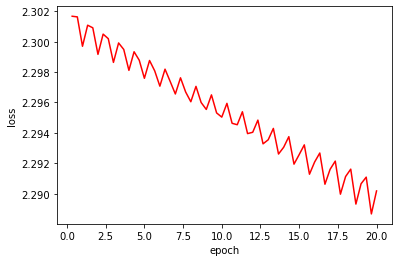

In [ ]:
dnnc = ScratchDeepNeuralNetrowkClassifier()
dnnc.fit(X_train, y_train, X_val, y_val, pinit="Initializer", pact1="Tanh", pact2="logsumexp", popt="SGD",
        cinit = "InitializerConv1d", cact = "ReLU", copt = "SGD",
        out_channel = 20, in_channel = 1, filter_size = 3, padding_size = 0, stride_size = 1)

In [ ]:
dnnc.predict(X_val[0:20])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

### 【問題2】1次元畳み込み後の出力サイズの計算

In [ ]:
X=np.array([1,2,3,4]) # X　入力サイズ
W=np.array([3,5,7]) # ウエイト
b=1 # バイアス
pad=0 #パディング
strd=1 #ストライド

N_out = int((len(X) + 2*pad - W.shape[0]) / strd) + 1
print(N_out)

2


### 【問題3】小さな配列での1次元畳み込み層の実験

In [ ]:
# Forward Propergation
# Xの要素の位置をストライドして計算
X=np.array([1,2,3,4])
W=np.array([3,5,7])
b=1
pad=0
strd=1

N_out = int((len(X) + 2*pad - W.shape[0]) / strd) + 1 # 【問題２】1次元畳み込み後の出力サイズの計算
Yhat = np.array([])

for i in range(N_out): # ストライドする分はループが必要か
    Yhat = np.append(Yhat, int(X[i:i+len(W)].dot(W) + b))
print(Yhat.astype(int))

[35 50]


In [ ]:
# Back Propergation

a=np.zeros([len(X)])
delta_a = np.array([10, 20])

# Xを更新
aX=np.array([])

for i in range(N_out): # ストライドする分はループが必要か
    a=np.zeros([X.shape[0]])
    for j in range(W.shape[0]): # ストライドした分、ずらしながらaに格納するループ
        a[j+i]=W[j]
    aX = np.append(aX,a).reshape(N_out,-1)
aX = delta_a.dot(aX)
print("aX={}".format(aX))

# Wを更新
indexes = np.array([])
aW = np.array([])

for i in range(N_out): # ストライドする分はループが必要か
    indexes = np.append(indexes, [np.arange(i,W.shape[0]+i)]).astype(np.int) # ([[1, 2, 3], [2, 3, 4]])
aW = delta_a.reshape(1,-1).dot(X[indexes].reshape(N_out,-1)).reshape(-1)
print("aW={}".format(aW))

# Bを更新
aB = np.sum(delta_a)
print("aB={}".format(aB))

aX=[ 30. 110. 170. 140.]
aW=[ 50  80 110]
aB=30


### 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成

In [ ]:
# フォワード
X=np.array([[1, 2, 3, 4], [2, 3, 4, 5]])
W = np.ones((3, 2, 3))
b=np.array([1, 2, 3])

In [ ]:
# Forward Propergation
# Xの要素の位置をストライドして計算

pad=0
strd=1

Yhat = np.array([])

N_out = int((X.shape[1] + 2*pad - W.shape[2]) / strd) + 1 # 【問題２】1次元畳み込み後の出力サイズの計算

for j in range(W.shape[0]):
    for i in range(N_out): # ストライドする分はループが必要か
        Yhat_tmp = 0
        for h in range(X.shape[0]):
            Yhat_tmp += int(X[h, i:i+W.shape[2]].dot(W[j, i, :]))
        Yhat = np.append(Yhat, np.sum(Yhat_tmp, axis=0) + b[j])

Yhat = Yhat.reshape(W.shape[0], N_out)
print(Yhat)

[[16. 22.]
 [17. 23.]
 [18. 24.]]


In [ ]:
# バックワード
delta_a = np.array([[10, 20],
                    [20,30],
                    [30,40]])

In [ ]:
# Back Propergation

# Xを更新
aX = np.zeros([2,4])
for j in range(W.shape[0]):
    for i in range(W.shape[1]):
        for h in range(W.shape[2]):
            for k in range(N_out):
                aX[i, h+k] += W[j, i, h] * delta_a[j, k]
print("aX={}".format(aX))

# Wを更新
aW = np.zeros([3,2,3])
for j in range(W.shape[0]):
    for i in range(W.shape[1]):
        for h in range(W.shape[2]):
            for k in range(N_out):
                aW[j, i, h] += X[i, h+k] * delta_a[j, k]
print("aW={}".format(aW))

# Bを更新
aB = np.sum(delta_a, axis=1)
print("aB={}".format(aB))

aX=[[ 60. 150. 150.  90.]
 [ 60. 150. 150.  90.]]
aW=[[[ 50.  80. 110.]
  [ 80. 110. 140.]]

 [[ 80. 130. 180.]
  [130. 180. 230.]]

 [[110. 180. 250.]
  [180. 250. 320.]]]
aB=[30 50 70]


### 【問題6】（アドバンス課題）ミニバッチへの対応

In [ ]:
# フォワード
X=np.array([[1, 2, 3, 4], [2, 3, 4, 5]]*3).reshape(3,2,4)
W = np.ones((3, 2, 3))
B=np.array([1, 2, 3])

In [ ]:
# Forward Propergation
# Xの要素の位置をストライドして計算

pad=0
strd=1

N_out = int((X.shape[2] + 2*pad - W.shape[2]) / strd) + 1 # 【問題２】1次元畳み込み後の出力サイズの計算

a = np.array([])
for n in range(X.shape[0]):
    Yhat = np.array([])
    for j in range(N_out):
        Yhat_tmp = 0
        for i in range(X.shape[1]): # ストライドする分はループが必要か
            Yhat_tmp += X[n, i, j:j+W.shape[2]].dot(W[n, i, :])
        Yhat = np.append(Yhat, np.sum(Yhat_tmp, axis=0) + B[n])
            
    a = np.append(a, Yhat)
    
a = a.reshape(X.shape[0], N_out)

print(a)

[[16. 22.]
 [17. 23.]
 [18. 24.]]


In [ ]:
# バックワード
delta_a = np.array([[10, 20],
                    [20,30],
                    [30,40]]*3).reshape(3,3,2)


In [ ]:
# Back Propergation

# Xを更新
aX = np.zeros(X.shape)
for n in range(X.shape[0]):
    for j in range(W.shape[0]):
        for i in range(W.shape[1]):
            for h in range(W.shape[2]):
                for k in range(N_out):
                    aX[n, i, h+k] += W[j, i, h] * delta_a[n, j, k]
print("aX={}".format(aX))

# Wを更新
aW = np.zeros([3,2,3])
for n in range(X.shape[0]):
    for j in range(W.shape[0]):
        for i in range(W.shape[1]):
            for h in range(W.shape[2]):
                for k in range(N_out):
                    aW[j, i, h] += X[n, i, h+k] * delta_a[n, j, k]
print("aW={}".format(aW))

# Bを更新
aB = np.sum(delta_a, axis=1)
print("aB={}".format(aB))

aX=[[[ 60. 150. 150.  90.]
  [ 60. 150. 150.  90.]]

 [[ 60. 150. 150.  90.]
  [ 60. 150. 150.  90.]]

 [[ 60. 150. 150.  90.]
  [ 60. 150. 150.  90.]]]
aW=[[[150. 240. 330.]
  [240. 330. 420.]]

 [[240. 390. 540.]
  [390. 540. 690.]]

 [[330. 540. 750.]
  [540. 750. 960.]]]
aB=[[60 90]
 [60 90]
 [60 90]]
